seallm

In [4]:
import torch
import pandas as pd
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from unsloth import FastLanguageModel
from datasets import Dataset
from peft import LoraConfig, get_peft_model

# Load preprocessed data
data_path = r"/home/visal/Documents/Formatted_Training_Data.csv"  # Ensure data is saved in this path
df = pd.read_csv(data_path)

def process_data(examples):
    return {"prompt": examples["prompt"], "response": examples["response"]}

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.map(process_data, batched=True)

# Load Tokenizer Separately
tokenizer = AutoTokenizer.from_pretrained("SeaLLMs/SeaLLMs-v3-1.5B-Chat", trust_remote_code=True)

# Define 4-bit Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # Normalized Float 4 for better accuracy
)

# Load Model with Quantization
model_name = "SeaLLMs/SeaLLMs-v3-1.5B-Chat"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# Apply LoRA (Low-Rank Adaptation) for Efficient Fine-tuning
lora_config = LoraConfig(
    r=8,  # Rank size
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_proj", "v_proj"],  # Apply LoRA only on specific layers
)
model = get_peft_model(model, lora_config)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=1,  # Adjust batch size for low VRAM
    gradient_accumulation_steps=4,  # Simulate larger batch sizes
    optim="adamw_bnb_8bit",  # Use memory-efficient optimizer
    num_train_epochs=3,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-4,
    fp16=True,  # Enable mixed precision training
    report_to="none",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

# Plot Training Loss
def plot_loss(log_file="./output/trainer_state.json"):
    import json
    import matplotlib.pyplot as plt
    
    with open(log_file) as f:
        logs = json.load(f)
    
    steps = [log["step"] for log in logs["log_history"] if "loss" in log]
    losses = [log["loss"] for log in logs["log_history"] if "loss" in log]
    
    plt.plot(steps, losses, marker='o')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()

# Call plot function after training
plot_loss()

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


ValueError: No columns in the dataset match the model's forward method signature. The following columns have been ignored: [response, prompt]. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

In [1]:
import torch
import pandas as pd
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorForSeq2Seq
from unsloth import FastLanguageModel
from datasets import Dataset
from peft import LoraConfig, get_peft_model

# Load preprocessed data
data_path = "/home/visal/Documents/Formatted_Training_Data.csv"  # Updated path to match uploaded file
df = pd.read_csv(data_path)

# Load Tokenizer Separately
tokenizer = AutoTokenizer.from_pretrained("SeaLLMs/SeaLLMs-v3-1.5B-Chat", trust_remote_code=True)

# Tokenization Function
def tokenize_data(examples):
    inputs = tokenizer(examples["prompt"], truncation=True, padding="max_length", max_length=512)
    targets = tokenizer(examples["response"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = targets["input_ids"]
    return inputs

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize_data, batched=True, remove_columns=["prompt", "response"])

# Define 4-bit Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # Normalized Float 4 for better accuracy
)

# Load Model with Quantization
model_name = "SeaLLMs/SeaLLMs-v3-1.5B-Chat"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# Apply LoRA (Low-Rank Adaptation) for Efficient Fine-tuning
lora_config = LoraConfig(
    r=8,  # Rank size
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_proj", "v_proj"],  # Apply LoRA only on specific layers
)
model = get_peft_model(model, lora_config)
model.config.use_cache = False  # Required for LoRA fine-tuning

# Define Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=1,  # Adjust batch size for low VRAM
    gradient_accumulation_steps=4,  # Simulate larger batch sizes
    optim="adamw_bnb_8bit",  # Use memory-efficient optimizer
    num_train_epochs=2,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-4,
    fp16=True,  # Enable mixed precision training
    remove_unused_columns=False,  # Prevents dataset filtering issue
    report_to="none",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
100,1.768400
200,0.415400


FileNotFoundError: [Errno 2] No such file or directory: './output/trainer_state.json'

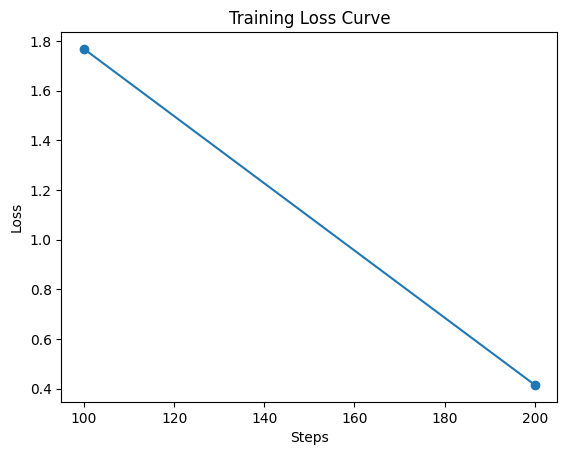

In [2]:

# Plot Training Loss
def plot_loss(log_file="/home/visal/Document/LLM_project/output/checkpoint-210/trainer_state.json"):
    import json
    import matplotlib.pyplot as plt
    
    with open(log_file) as f:
        logs = json.load(f)
    
    steps = [log["step"] for log in logs["log_history"] if "loss" in log]
    losses = [log["loss"] for log in logs["log_history"] if "loss" in log]
    
    plt.plot(steps, losses, marker='o')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()

# Call plot function after training
plot_loss()

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# Load trained LoRA adapter and base model
base_model_path = "SeaLLMs/SeaLLMs-v3-1.5B-Chat"  # Base model path
adapter_model_path = "results/checkpoint-210"  # Path to LoRA adapter

# Load tokenizer from base model
print("Loading tokenizer from base model...")
tokenizer = AutoTokenizer.from_pretrained(base_model_path, trust_remote_code=True)

# Define quantization config for efficient loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Ensure model loads in 4-bit mode
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # Normalized Float 4 for better accuracy
)

# Load base model with quantization
print("Loading base model with 4-bit quantization...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    quantization_config=bnb_config,
    device_map={"": 0} if torch.cuda.is_available() else "cpu",
)

# Load LoRA adapter on top of the base model
print("Loading LoRA adapter...")
model = PeftModel.from_pretrained(base_model, adapter_model_path)
model = model.merge_and_unload()  # Merge LoRA weights with base model
model.eval()

# Function to chat with the model
def chat():
    print("Chatbot is ready! Type 'exit' to stop.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            break
        
        # Tokenize input and generate response
        inputs = tokenizer(user_input, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
        with torch.no_grad():
            output = model.generate(**inputs, max_length=512, pad_token_id=tokenizer.eos_token_id)
        
        response = tokenizer.decode(output[0], skip_special_tokens=True)
        print("Chatbot:", response)

# Run the chatbot
if __name__ == "__main__":
    chat()

Loading tokenizer from base model...
Loading base model with 4-bit quantization...
Loading LoRA adapter...
Chatbot is ready! Type 'exit' to stop.
Chatbot: បកក្រោយ ១៥.១៤ ម៉ែត នៅល្បឿន ៦.៩៨ ម៉ែត្រក្នុង១វិនាទី រួចហើយ បង្វែស្ដាំ ៨៤ ដឺក្រេ។
[ការប្រកាសថ្លៃសមីការៈ ០4.២] ការទិញផល (កាំភ្លេក់) 70 ដឺក្រេ៖ ១៧០ ដឺក្រេ * ៣.៦ កាត់/ៗ កាក្រោយ = ៤១០ កាត់/ៗ ការទិញផល ១ កាំភ្លេក់៖ ៤១០ កាតោ / ១៧០ = ២.០០០9 កាំភ្លេក់.
[ការប្រកាសថ្លៃសមីការៈ ០6.៤] ការទិញផល (កំដៅ) ២៩ ដឺក្រេ៖ ៧១៨ ដឺក្រេ * ៣.៩៥ កាតោ/ៗ កាក្រោយ = ២៣០២.៥៥ កាតោ/ៗ ការទិញផល ១ កំដៅ៖ ២៣០២.៥៥ កាតោ / ២៩១ = ៧.១០០០៥ កំដ
Chatbot: [{'action': 'move', 'params': {'distance':  8.93, 'is_forward':  true, 'unit': 'meter'}},{'action': 'move', 'params': {'distance':  8.93, 'is_forward':  true, 'unit': 'meter'}},{'action': 'move', 'params': {'distance':  17.86, 'is_forward':  false, 'unit': 'meter'}}] 
    #print(json.loads(response))
    result = []
    for actionItem in response["result"]["items"]:
        if actionItem["action"] == "move":
            #extracting the